## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -5.009902     530.969362   -14.309693     -21.535757   
1            2     -5.009902     530.969362   -14.309693     -21.535757   
2            3     -5.009902     530.969362   -14.309693     -21.535757   
3            4     -5.009902     530.969362   -14.309693     -21.535757   
4            5     -5.009902     530.969362   -14.309693     -21.535757   
...        ...           ...            ...          ...            ...   
1752345     46      3.859826     597.901711    25.170685      35.938051   
1752346     47      3.859826     597.901711    25.170685      35.938051   
1752347     48      3.859826     597.901711    25.170685      35.938051   
1752348     49      3.859826     597.901711    25.170685      35.938051   
1752349     50      3.859826     597.901711    25.170685      35.938051   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 35047
Number of training points: 1051400


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns = ['depth', 'Area_m2', 'Uw',
                 'buoyancy', 'day_of_year', 'time_of_day',  'ice', 'snow', 'snowice','diffusivity', 'temp_total05']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day',
                   'ice', 'snow', 'snowice', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns = ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_diff02']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns = ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',
                   'temp_heat01']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(1051400, 45)
(700950, 45)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [20]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m3_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m3_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)

        m4_pred = ice_model(m4_input)

        
        #print(m1_pred)
        
        if plot:
            m4_y_true = x[:, m4_output_column_ix[0]] * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
            m4_y_pred = m4_pred * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))


        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)
            
        if plot:
            m1_y_true = x[:, m1_output_column_ix] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
            print("RMSE of after m3", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * std + mean
            m3_y_pred = m3_pred * std + mean
            rmse_models[ix, 4] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m4", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        y_true = x[:, m3_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m3_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [21]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [22]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0041027484
RMSE of after m1 0.016025735
RMSE of after m3 0.043119613
RMSE of after m4 0.04427228
RMSE of after m0 0.006662367
RMSE of after m1 0.052950934
RMSE of after m3 0.16314222
RMSE of after m4 0.16213292
RMSE of after m0 0.008104843
RMSE of after m1 0.028474016
RMSE of after m3 0.09171018
RMSE of after m4 0.09131163
RMSE of after m0 0.0076912576
RMSE of after m1 0.020512382
RMSE of after m3 0.03286777
RMSE of after m4 0.032921426
RMSE of after m0 0.007948776
RMSE of after m1 0.018048972
RMSE of after m3 0.026989076
RMSE of after m4 0.025157684
RMSE of after m0 0.007042731
RMSE of after m1 0.015575844
RMSE of after m3 0.023221822
RMSE of after m4 0.021325504
RMSE of after m0 0.005781268
RMSE of after m1 0.013841938
RMSE of after m3 0.020438237
RMSE of after m4 0.020648709
RMSE of after m0 0.008311805
RMSE of after m1 0.018056948
RMSE of after m3 0.021044934
RMSE of after m4 0.02055467
RMSE of after m0 0.0074767084
RMSE of after m1 0.014158648
RMSE of after m3 0

RMSE of after m0 0.009069173
RMSE of after m1 0.014877185
RMSE of after m3 0.013675042
RMSE of after m4 0.01561582
RMSE of after m0 0.009013863
RMSE of after m1 0.014671118
RMSE of after m3 0.017733833
RMSE of after m4 0.020816451
RMSE of after m0 0.0123185655
RMSE of after m1 0.015904166
RMSE of after m3 0.017519798
RMSE of after m4 0.021073181
RMSE of after m0 0.015707137
RMSE of after m1 0.018192112
RMSE of after m3 0.016759627
RMSE of after m4 0.019617593
RMSE of after m0 0.032782633
RMSE of after m1 0.026650244
RMSE of after m3 0.031143114
RMSE of after m4 0.035069175
RMSE of after m0 0.013633402
RMSE of after m1 0.016652446
RMSE of after m3 0.018852862
RMSE of after m4 0.021409804
RMSE of after m0 0.009888358
RMSE of after m1 0.014916181
RMSE of after m3 0.01223858
RMSE of after m4 0.012809498
RMSE of after m0 0.00978212
RMSE of after m1 0.024925618
RMSE of after m3 0.020698864
RMSE of after m4 0.016476255
RMSE of after m0 0.010077925
RMSE of after m1 0.015043265
RMSE of after m3

RMSE of after m1 0.005496004
RMSE of after m3 0.029897684
RMSE of after m4 0.029696338
RMSE of after m0 0.0054668356
RMSE of after m1 0.006607147
RMSE of after m3 0.013443685
RMSE of after m4 0.013305278
RMSE of after m0 0.008731316
RMSE of after m1 0.009738127
RMSE of after m3 0.028263547
RMSE of after m4 0.028603755
RMSE of after m0 0.004421173
RMSE of after m1 0.005077878
RMSE of after m3 0.040455274
RMSE of after m4 0.039469805
RMSE of after m0 0.0041099917
RMSE of after m1 0.004126291
RMSE of after m3 0.025233554
RMSE of after m4 0.024383523
RMSE of after m0 0.008727694
RMSE of after m1 0.010462833
RMSE of after m3 0.09181647
RMSE of after m4 0.093074694
RMSE of after m0 0.0033532714
RMSE of after m1 0.0044959662
RMSE of after m3 0.045849964
RMSE of after m4 0.041828997
RMSE of after m0 0.0044723274
RMSE of after m1 0.005571258
RMSE of after m3 0.025281379
RMSE of after m4 0.024764424
RMSE of after m0 0.009286572
RMSE of after m1 0.010607165
RMSE of after m3 0.03594047
RMSE of aft

RMSE of after m1 0.006114881
RMSE of after m3 0.024473004
RMSE of after m4 0.02231158
RMSE of after m0 0.006059677
RMSE of after m1 0.0068862513
RMSE of after m3 0.022592397
RMSE of after m4 0.022394221
RMSE of after m0 0.01099489
RMSE of after m1 0.01090985
RMSE of after m3 0.045720063
RMSE of after m4 0.04622101
RMSE of after m0 0.005817933
RMSE of after m1 0.0061001577
RMSE of after m3 0.020577619
RMSE of after m4 0.01796051
RMSE of after m0 0.009408917
RMSE of after m1 0.009071203
RMSE of after m3 0.035836354
RMSE of after m4 0.0333336
RMSE of after m0 0.007145083
RMSE of after m1 0.0072375075
RMSE of after m3 0.050623983
RMSE of after m4 0.04735731
RMSE of after m0 0.0064638336
RMSE of after m1 0.006424813
RMSE of after m3 0.045163173
RMSE of after m4 0.04291067
RMSE of after m0 0.004950841
RMSE of after m1 0.0056623095
RMSE of after m3 0.028776895
RMSE of after m4 0.029162196
RMSE of after m0 0.0044096587
RMSE of after m1 0.00537261
RMSE of after m3 0.019062093
RMSE of after m4 0

RMSE of after m4 0.04144324
RMSE of after m0 0.006326332
RMSE of after m1 0.007624624
RMSE of after m3 0.054915458
RMSE of after m4 0.055003915
RMSE of after m0 0.0061111674
RMSE of after m1 0.007754946
RMSE of after m3 0.032980382
RMSE of after m4 0.032713413
RMSE of after m0 0.0057633505
RMSE of after m1 0.007325939
RMSE of after m3 0.0210878
RMSE of after m4 0.023085002
RMSE of after m0 0.0043658135
RMSE of after m1 0.006584301
RMSE of after m3 0.020020075
RMSE of after m4 0.021291215
RMSE of after m0 0.005525432
RMSE of after m1 0.0069593377
RMSE of after m3 0.023014631
RMSE of after m4 0.022926576
RMSE of after m0 0.00823356
RMSE of after m1 0.009262279
RMSE of after m3 0.026457746
RMSE of after m4 0.029242318
RMSE of after m0 0.0050647366
RMSE of after m1 0.006774194
RMSE of after m3 0.023820221
RMSE of after m4 0.024309514
RMSE of after m0 0.0058701714
RMSE of after m1 0.0072281016
RMSE of after m3 0.031844217
RMSE of after m4 0.02924117
RMSE of after m0 0.005187768
RMSE of afte

RMSE of after m4 0.023259338
RMSE of after m0 0.00757654
RMSE of after m1 0.010918994
RMSE of after m3 0.046560936
RMSE of after m4 0.042917233
RMSE of after m0 0.014829436
RMSE of after m1 0.015350763
RMSE of after m3 0.078522176
RMSE of after m4 0.07550215
RMSE of after m0 0.010968183
RMSE of after m1 0.012706176
RMSE of after m3 0.14557517
RMSE of after m4 0.1492089
RMSE of after m0 0.011797608
RMSE of after m1 0.0147209205
RMSE of after m3 0.21862191
RMSE of after m4 0.21549566
RMSE of after m0 0.011467423
RMSE of after m1 0.0625546
RMSE of after m3 0.06970179
RMSE of after m4 0.072050564
RMSE of after m0 0.004750162
RMSE of after m1 0.043975987
RMSE of after m3 0.07590611
RMSE of after m4 0.07700498
RMSE of after m0 0.0052640275
RMSE of after m1 0.032174084
RMSE of after m3 0.055640493
RMSE of after m4 0.056447677
RMSE of after m0 0.0053158416
RMSE of after m1 0.021599984
RMSE of after m3 0.060512003
RMSE of after m4 0.061741874
RMSE of after m0 0.0059497803
RMSE of after m1 0.010

RMSE of after m1 0.014779984
RMSE of after m3 0.016136564
RMSE of after m4 0.013478563
RMSE of after m0 0.010236211
RMSE of after m1 0.017998077
RMSE of after m3 0.0174946
RMSE of after m4 0.012358433
RMSE of after m0 0.0101528475
RMSE of after m1 0.019233268
RMSE of after m3 0.019243306
RMSE of after m4 0.013413304
RMSE of after m0 0.010269052
RMSE of after m1 0.021547219
RMSE of after m3 0.024013381
RMSE of after m4 0.016856693
RMSE of after m0 0.010149439
RMSE of after m1 0.023053419
RMSE of after m3 0.028097536
RMSE of after m4 0.02144269
RMSE of after m0 0.009716905
RMSE of after m1 0.024074364
RMSE of after m3 0.031682156
RMSE of after m4 0.024547499
RMSE of after m0 0.009871145
RMSE of after m1 0.027104435
RMSE of after m3 0.033189043
RMSE of after m4 0.026236856
RMSE of after m0 0.01008236
RMSE of after m1 0.033673905
RMSE of after m3 0.04841261
RMSE of after m4 0.043483753
RMSE of after m0 0.00968111
RMSE of after m1 0.01563426
RMSE of after m3 0.030347748
RMSE of after m4 0.0

RMSE of after m1 0.028258504
RMSE of after m3 0.022995915
RMSE of after m4 0.011875234
RMSE of after m0 0.006393435
RMSE of after m1 0.009057318
RMSE of after m3 0.012385076
RMSE of after m4 0.011248893
RMSE of after m0 0.0060197976
RMSE of after m1 0.007937574
RMSE of after m3 0.0117650265
RMSE of after m4 0.015275356
RMSE of after m0 0.005813044
RMSE of after m1 0.006582472
RMSE of after m3 0.018627984
RMSE of after m4 0.021974387
RMSE of after m0 0.0083922185
RMSE of after m1 0.008010428
RMSE of after m3 0.069884695
RMSE of after m4 0.068506084
RMSE of after m0 0.005646124
RMSE of after m1 0.0061854627
RMSE of after m3 0.046292514
RMSE of after m4 0.04524084
RMSE of after m0 0.0037257879
RMSE of after m1 0.005228905
RMSE of after m3 0.054488298
RMSE of after m4 0.0548334
RMSE of after m0 0.004493544
RMSE of after m1 0.0051888158
RMSE of after m3 0.026398674
RMSE of after m4 0.026848758
RMSE of after m0 0.0046728603
RMSE of after m1 0.0049950043
RMSE of after m3 0.012362725
RMSE of a

RMSE of after m1 0.00398366
RMSE of after m3 0.010304524
RMSE of after m4 0.010048266
RMSE of after m0 0.006369579
RMSE of after m1 0.0071751764
RMSE of after m3 0.01734991
RMSE of after m4 0.017646007
RMSE of after m0 0.0039389096
RMSE of after m1 0.0053090444
RMSE of after m3 0.008669957
RMSE of after m4 0.008296404
RMSE of after m0 0.0038296646
RMSE of after m1 0.004719238
RMSE of after m3 0.015372296
RMSE of after m4 0.013373593
RMSE of after m0 0.0057046614
RMSE of after m1 0.0060059484
RMSE of after m3 0.0492976
RMSE of after m4 0.048042174
RMSE of after m0 0.004624655
RMSE of after m1 0.0047583417
RMSE of after m3 0.030459799
RMSE of after m4 0.029882887
RMSE of after m0 0.0045722574
RMSE of after m1 0.0048832027
RMSE of after m3 0.02827606
RMSE of after m4 0.025898783
RMSE of after m0 0.004680032
RMSE of after m1 0.0048936256
RMSE of after m3 0.025694378
RMSE of after m4 0.025184501
RMSE of after m0 0.003951966
RMSE of after m1 0.004124022
RMSE of after m3 0.015413833
RMSE of a

RMSE of after m4 0.015523684
RMSE of after m0 0.0046410873
RMSE of after m1 0.005774327
RMSE of after m3 0.017379664
RMSE of after m4 0.018507184
RMSE of after m0 0.0045433035
RMSE of after m1 0.0063921576
RMSE of after m3 0.015749892
RMSE of after m4 0.01627363
RMSE of after m0 0.0047633694
RMSE of after m1 0.006361723
RMSE of after m3 0.022722073
RMSE of after m4 0.023694485
RMSE of after m0 0.010186537
RMSE of after m1 0.010252808
RMSE of after m3 0.07138323
RMSE of after m4 0.057920426
RMSE of after m0 0.0072621317
RMSE of after m1 0.0072616437
RMSE of after m3 0.062725246
RMSE of after m4 0.06001954
RMSE of after m0 0.0044767833
RMSE of after m1 0.0063712946
RMSE of after m3 0.019004654
RMSE of after m4 0.017878808
RMSE of after m0 0.004635643
RMSE of after m1 0.0062287976
RMSE of after m3 0.010163178
RMSE of after m4 0.012969027
RMSE of after m0 0.0045338576
RMSE of after m1 0.0059574307
RMSE of after m3 0.013966735
RMSE of after m4 0.016095463
RMSE of after m0 0.0046953005
RMSE 

RMSE of after m1 0.007712868
RMSE of after m3 0.024909552
RMSE of after m4 0.02753249
RMSE of after m0 0.0068898196
RMSE of after m1 0.008853399
RMSE of after m3 0.03790544
RMSE of after m4 0.036249787
RMSE of after m0 0.0061829616
RMSE of after m1 0.0072951196
RMSE of after m3 0.032706674
RMSE of after m4 0.03295873
RMSE of after m0 0.0055734883
RMSE of after m1 0.0067326976
RMSE of after m3 0.031843126
RMSE of after m4 0.030617226
RMSE of after m0 0.0048967497
RMSE of after m1 0.0062009185
RMSE of after m3 0.026172845
RMSE of after m4 0.027141768
RMSE of after m0 0.0061120098
RMSE of after m1 0.0064613237
RMSE of after m3 0.04286619
RMSE of after m4 0.03520467
RMSE of after m0 0.0051231743
RMSE of after m1 0.0064375233
RMSE of after m3 0.047251735
RMSE of after m4 0.046987202
RMSE of after m0 0.0048861536
RMSE of after m1 0.0065303803
RMSE of after m3 0.024486622
RMSE of after m4 0.018426942
RMSE of after m0 0.0053907027
RMSE of after m1 0.006697183
RMSE of after m3 0.017079115
RMSE 

RMSE of after m0 0.006109041
RMSE of after m1 0.014285197
RMSE of after m3 0.020580776
RMSE of after m4 0.020673389
RMSE of after m0 0.0054096137
RMSE of after m1 0.0118114175
RMSE of after m3 0.019628938
RMSE of after m4 0.019410137
RMSE of after m0 0.0058878744
RMSE of after m1 0.012453103
RMSE of after m3 0.019429555
RMSE of after m4 0.019496197
RMSE of after m0 0.006117646
RMSE of after m1 0.0126378825
RMSE of after m3 0.019867942
RMSE of after m4 0.02026998
RMSE of after m0 0.0063299965
RMSE of after m1 0.014096912
RMSE of after m3 0.032424137
RMSE of after m4 0.033161707
RMSE of after m0 0.008067218
RMSE of after m1 0.016208813
RMSE of after m3 0.02990065
RMSE of after m4 0.029685294
RMSE of after m0 0.0056790155
RMSE of after m1 0.013167526
RMSE of after m3 0.02372637
RMSE of after m4 0.022691127
RMSE of after m0 0.005849534
RMSE of after m1 0.013892198
RMSE of after m3 0.022931324
RMSE of after m4 0.022316854
RMSE of after m0 0.0063323425
RMSE of after m1 0.016250573
RMSE of af

RMSE of after m3 0.022467073
RMSE of after m4 0.017626848
RMSE of after m0 0.009722614
RMSE of after m1 0.024047967
RMSE of after m3 0.023284832
RMSE of after m4 0.019421393
RMSE of after m0 0.011291534
RMSE of after m1 0.025820836
RMSE of after m3 0.023387054
RMSE of after m4 0.020277768
RMSE of after m0 0.009505263
RMSE of after m1 0.024469396
RMSE of after m3 0.020851914
RMSE of after m4 0.01571761
RMSE of after m0 0.010764805
RMSE of after m1 0.02124916
RMSE of after m3 0.039676327
RMSE of after m4 0.037892733
RMSE of after m0 0.011081794
RMSE of after m1 0.019014427
RMSE of after m3 0.021400122
RMSE of after m4 0.018086057
RMSE of after m0 0.01104164
RMSE of after m1 0.019185912
RMSE of after m3 0.020681862
RMSE of after m4 0.018124606
RMSE of after m0 0.011077406
RMSE of after m1 0.022462117
RMSE of after m3 0.02062335
RMSE of after m4 0.018846408
RMSE of after m0 0.01025045
RMSE of after m1 0.022747792
RMSE of after m3 0.021129915
RMSE of after m4 0.018942783
RMSE of after m0 0.

RMSE of after m1 0.023591684
RMSE of after m3 0.02217391
RMSE of after m4 0.018004682
RMSE of after m0 0.013409887
RMSE of after m1 0.023483507
RMSE of after m3 0.024930703
RMSE of after m4 0.018605491
RMSE of after m0 0.012561833
RMSE of after m1 0.0216819
RMSE of after m3 0.02168934
RMSE of after m4 0.020475058
RMSE of after m0 0.013032312
RMSE of after m1 0.022977691
RMSE of after m3 0.026827943
RMSE of after m4 0.024921231
RMSE of after m0 0.013605573
RMSE of after m1 0.02384006
RMSE of after m3 0.028132081
RMSE of after m4 0.02550677
RMSE of after m0 0.013502231
RMSE of after m1 0.022777952
RMSE of after m3 0.023174582
RMSE of after m4 0.021760168
RMSE of after m0 0.013545122
RMSE of after m1 0.03509956
RMSE of after m3 0.0356463
RMSE of after m4 0.02985035
RMSE of after m0 0.0152888475
RMSE of after m1 0.043245234
RMSE of after m3 0.051084533
RMSE of after m4 0.04449529
RMSE of after m0 0.013594599
RMSE of after m1 0.03570338
RMSE of after m3 0.040962826
RMSE of after m4 0.035984

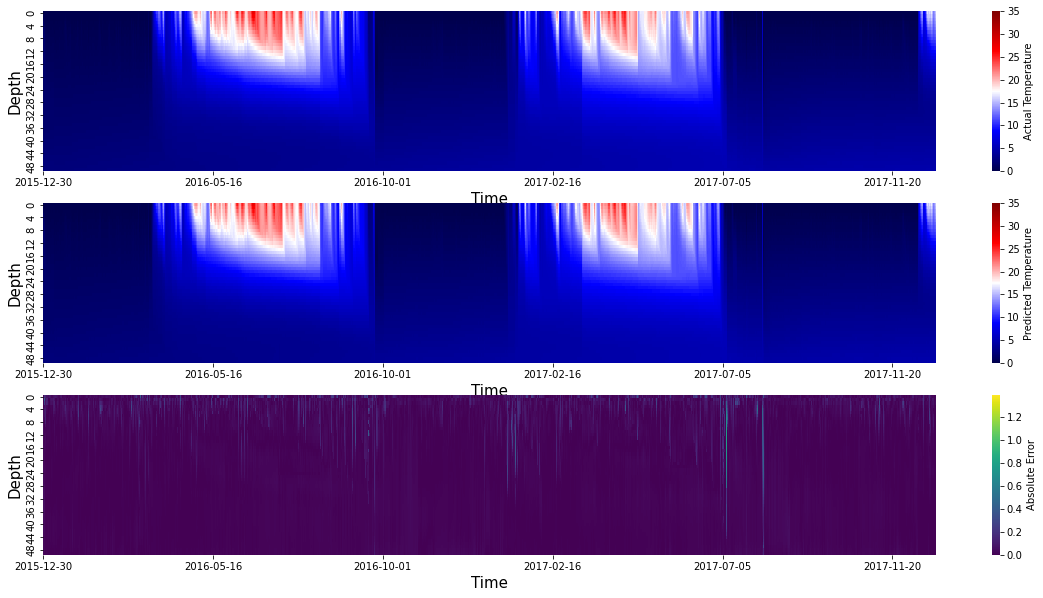

In [23]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

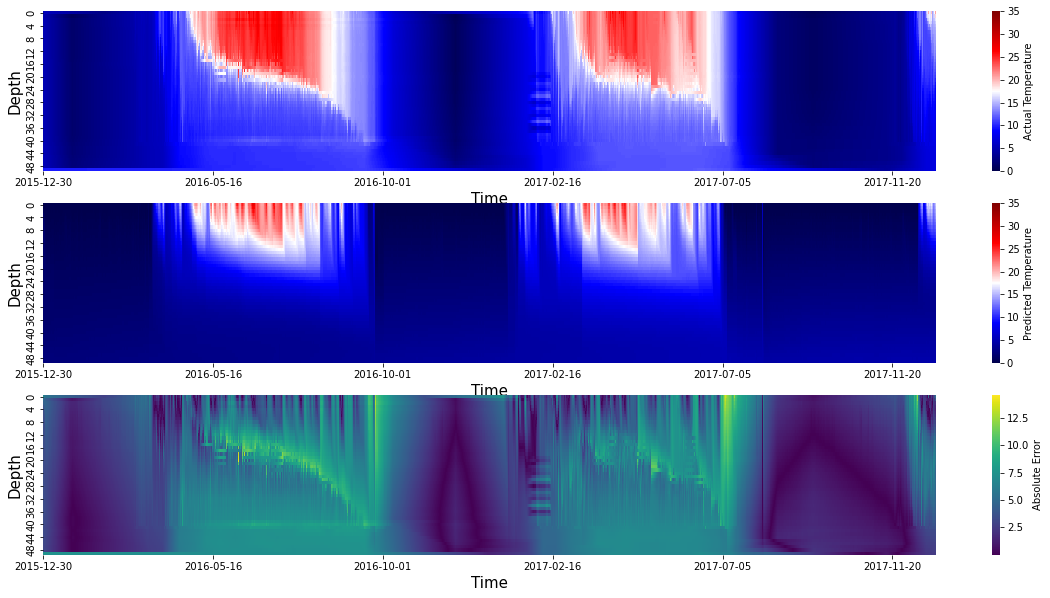

In [24]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [25]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0059419116
RMSE of after m1 0.006902804
RMSE of after m3 0.016780635
RMSE of after m4 0.016891759
RMSE of after m0 0.007157667
RMSE of after m1 0.007972541
RMSE of after m3 0.021013761
RMSE of after m4 0.02072338
RMSE of after m0 0.0047542206
RMSE of after m1 0.005939046
RMSE of after m3 0.012801656
RMSE of after m4 0.01209315
RMSE of after m0 0.0051618326
RMSE of after m1 0.0064778053
RMSE of after m3 0.015072842
RMSE of after m4 0.015916865
RMSE of after m0 0.005379781
RMSE of after m1 0.006945205
RMSE of after m3 0.016183257
RMSE of after m4 0.01776428
RMSE of after m0 0.005166138
RMSE of after m1 0.00688493
RMSE of after m3 0.014851021
RMSE of after m4 0.01684319
RMSE of after m0 0.005269972
RMSE of after m1 0.0065093883
RMSE of after m3 0.029091243
RMSE of after m4 0.026493303
RMSE of after m0 0.0053153355
RMSE of after m1 0.006314988
RMSE of after m3 0.020131234
RMSE of after m4 0.017474853
RMSE of after m0 0.0046447846
RMSE of after m1 0.005735461
RMSE of afte

RMSE of after m1 0.0053185276
RMSE of after m3 0.020810362
RMSE of after m4 0.018321816
RMSE of after m0 0.004400697
RMSE of after m1 0.0052654603
RMSE of after m3 0.016950266
RMSE of after m4 0.01647212
RMSE of after m0 0.004251443
RMSE of after m1 0.005222451
RMSE of after m3 0.013173076
RMSE of after m4 0.0147285145
RMSE of after m0 0.0042958637
RMSE of after m1 0.005340063
RMSE of after m3 0.014170366
RMSE of after m4 0.016140945
RMSE of after m0 0.004362774
RMSE of after m1 0.005513797
RMSE of after m3 0.015638579
RMSE of after m4 0.016715806
RMSE of after m0 0.004997493
RMSE of after m1 0.0059960084
RMSE of after m3 0.022087649
RMSE of after m4 0.020907039
RMSE of after m0 0.004648825
RMSE of after m1 0.0054050963
RMSE of after m3 0.017610451
RMSE of after m4 0.015981508
RMSE of after m0 0.003995644
RMSE of after m1 0.004911515
RMSE of after m3 0.017050665
RMSE of after m4 0.015978253
RMSE of after m0 0.0052147177
RMSE of after m1 0.0056370525
RMSE of after m3 0.026639318
RMSE of

RMSE of after m4 0.02890305
RMSE of after m0 0.013241572
RMSE of after m1 0.013726204
RMSE of after m3 0.11634369
RMSE of after m4 0.11578016
RMSE of after m0 0.020242635
RMSE of after m1 0.020889586
RMSE of after m3 0.22394812
RMSE of after m4 0.20720845
RMSE of after m0 0.0053321305
RMSE of after m1 0.006537798
RMSE of after m3 0.063110515
RMSE of after m4 0.05762327
RMSE of after m0 0.005444714
RMSE of after m1 0.00560691
RMSE of after m3 0.040456597
RMSE of after m4 0.04327183
RMSE of after m0 0.0048649157
RMSE of after m1 0.0047935587
RMSE of after m3 0.024676584
RMSE of after m4 0.022710344
RMSE of after m0 0.0054496257
RMSE of after m1 0.005318257
RMSE of after m3 0.0734496
RMSE of after m4 0.06500328
RMSE of after m0 0.004818744
RMSE of after m1 0.009874662
RMSE of after m3 0.14498484
RMSE of after m4 0.14227317
RMSE of after m0 0.0068571786
RMSE of after m1 0.012455947
RMSE of after m3 0.10375042
RMSE of after m4 0.10350432
RMSE of after m0 0.00458896
RMSE of after m1 0.011903

RMSE of after m1 0.045151796
RMSE of after m3 0.043727905
RMSE of after m4 0.041336503
RMSE of after m0 0.0059521864
RMSE of after m1 0.041836157
RMSE of after m3 0.041891277
RMSE of after m4 0.03946319
RMSE of after m0 0.005937947
RMSE of after m1 0.029474173
RMSE of after m3 0.032819245
RMSE of after m4 0.030823069
RMSE of after m0 0.0062816683
RMSE of after m1 0.027751928
RMSE of after m3 0.026738703
RMSE of after m4 0.02480575
RMSE of after m0 0.0057434095
RMSE of after m1 0.024999421
RMSE of after m3 0.030854411
RMSE of after m4 0.028418476
RMSE of after m0 0.006109252
RMSE of after m1 0.023735467
RMSE of after m3 0.028712709
RMSE of after m4 0.02661001
RMSE of after m0 0.005988247
RMSE of after m1 0.023507543
RMSE of after m3 0.023547918
RMSE of after m4 0.022033857
RMSE of after m0 0.005486703
RMSE of after m1 0.022415388
RMSE of after m3 0.029226113
RMSE of after m4 0.027685512
RMSE of after m0 0.005965042
RMSE of after m1 0.022638544
RMSE of after m3 0.023058444
RMSE of after 

RMSE of after m3 0.3700039
RMSE of after m4 0.42736596
RMSE of after m0 0.06209704
RMSE of after m1 0.19712926
RMSE of after m3 0.3742757
RMSE of after m4 0.42840472
RMSE of after m0 0.059634257
RMSE of after m1 0.19944134
RMSE of after m3 0.36844605
RMSE of after m4 0.4233678
RMSE of after m0 0.06190334
RMSE of after m1 0.20821567
RMSE of after m3 0.39704075
RMSE of after m4 0.45343298
RMSE of after m0 0.06418137
RMSE of after m1 0.20601286
RMSE of after m3 0.39447895
RMSE of after m4 0.45937887
RMSE of after m0 0.054123033
RMSE of after m1 0.20430648
RMSE of after m3 0.3673806
RMSE of after m4 0.43584868
RMSE of after m0 0.048772503
RMSE of after m1 0.20269486
RMSE of after m3 0.3916623
RMSE of after m4 0.4624002
RMSE of after m0 0.057070404
RMSE of after m1 0.22015743
RMSE of after m3 0.4198311
RMSE of after m4 0.482622
RMSE of after m0 0.081837445
RMSE of after m1 0.21378964
RMSE of after m3 0.41941008
RMSE of after m4 0.4792515
RMSE of after m0 0.08383038
RMSE of after m1 0.217120

RMSE of after m4 0.0344705
RMSE of after m0 0.005280685
RMSE of after m1 0.005551075
RMSE of after m3 0.026083888
RMSE of after m4 0.025205547
RMSE of after m0 0.0057514515
RMSE of after m1 0.0059489966
RMSE of after m3 0.015675507
RMSE of after m4 0.014937198
RMSE of after m0 0.0049976786
RMSE of after m1 0.0053485706
RMSE of after m3 0.028756196
RMSE of after m4 0.025882013
RMSE of after m0 0.0046802233
RMSE of after m1 0.005027642
RMSE of after m3 0.013342168
RMSE of after m4 0.012934314
RMSE of after m0 0.0050406186
RMSE of after m1 0.0059503946
RMSE of after m3 0.010709408
RMSE of after m4 0.010667357
RMSE of after m0 0.004737943
RMSE of after m1 0.0058847843
RMSE of after m3 0.011022043
RMSE of after m4 0.010418718
RMSE of after m0 0.003634172
RMSE of after m1 0.0057067676
RMSE of after m3 0.011404806
RMSE of after m4 0.014330035
RMSE of after m0 0.0070990403
RMSE of after m1 0.009100977
RMSE of after m3 0.018735427
RMSE of after m4 0.020709258
RMSE of after m0 0.0065198527
RMSE 

RMSE of after m4 0.01571606
RMSE of after m0 0.005786529
RMSE of after m1 0.0062124203
RMSE of after m3 0.016763404
RMSE of after m4 0.015642282
RMSE of after m0 0.0053913635
RMSE of after m1 0.0060369675
RMSE of after m3 0.016375817
RMSE of after m4 0.01645334
RMSE of after m0 0.0060359975
RMSE of after m1 0.006004173
RMSE of after m3 0.013704055
RMSE of after m4 0.015599126
RMSE of after m0 0.0063688983
RMSE of after m1 0.006234775
RMSE of after m3 0.017515292
RMSE of after m4 0.018114122
RMSE of after m0 0.0056733037
RMSE of after m1 0.0059934855
RMSE of after m3 0.019364277
RMSE of after m4 0.020775463
RMSE of after m0 0.006143614
RMSE of after m1 0.006643497
RMSE of after m3 0.05065782
RMSE of after m4 0.05063387
RMSE of after m0 0.009129685
RMSE of after m1 0.00869524
RMSE of after m3 0.06725557
RMSE of after m4 0.06361437
RMSE of after m0 0.005989729
RMSE of after m1 0.006514954
RMSE of after m3 0.030846458
RMSE of after m4 0.027316488
RMSE of after m0 0.004347967
RMSE of after 

RMSE of after m0 0.0047559226
RMSE of after m1 0.005867533
RMSE of after m3 0.025501564
RMSE of after m4 0.02425243
RMSE of after m0 0.0043572993
RMSE of after m1 0.0063660378
RMSE of after m3 0.02672171
RMSE of after m4 0.027638335
RMSE of after m0 0.009541761
RMSE of after m1 0.0105675645
RMSE of after m3 0.039766587
RMSE of after m4 0.03908131
RMSE of after m0 0.010652665
RMSE of after m1 0.011332962
RMSE of after m3 0.036872968
RMSE of after m4 0.040008355
RMSE of after m0 0.0062764497
RMSE of after m1 0.0069491398
RMSE of after m3 0.017092953
RMSE of after m4 0.017696626
RMSE of after m0 0.0070268344
RMSE of after m1 0.0077662654
RMSE of after m3 0.03714926
RMSE of after m4 0.033539955
RMSE of after m0 0.0076765288
RMSE of after m1 0.00815065
RMSE of after m3 0.04492198
RMSE of after m4 0.04255494
RMSE of after m0 0.009303762
RMSE of after m1 0.008746632
RMSE of after m3 0.076045685
RMSE of after m4 0.071618155
RMSE of after m0 0.0052251164
RMSE of after m1 0.006497073
RMSE of aft

RMSE of after m1 0.08878667
RMSE of after m3 0.12155605
RMSE of after m4 0.11433935
RMSE of after m0 0.0068173544
RMSE of after m1 0.08657073
RMSE of after m3 0.11414729
RMSE of after m4 0.10466673
RMSE of after m0 0.006855696
RMSE of after m1 0.086653516
RMSE of after m3 0.113879114
RMSE of after m4 0.10411948
RMSE of after m0 0.0064499695
RMSE of after m1 0.08633532
RMSE of after m3 0.116260864
RMSE of after m4 0.10601384
RMSE of after m0 0.0061186217
RMSE of after m1 0.08597734
RMSE of after m3 0.1143223
RMSE of after m4 0.10416068
RMSE of after m0 0.006130102
RMSE of after m1 0.08643036
RMSE of after m3 0.11436518
RMSE of after m4 0.10356188
RMSE of after m0 0.0063025826
RMSE of after m1 0.08787431
RMSE of after m3 0.116412245
RMSE of after m4 0.10604808
RMSE of after m0 0.005942295
RMSE of after m1 0.0889053
RMSE of after m3 0.11479169
RMSE of after m4 0.10411668
RMSE of after m0 0.005972966
RMSE of after m1 0.089422345
RMSE of after m3 0.119636536
RMSE of after m4 0.10883806
RMSE

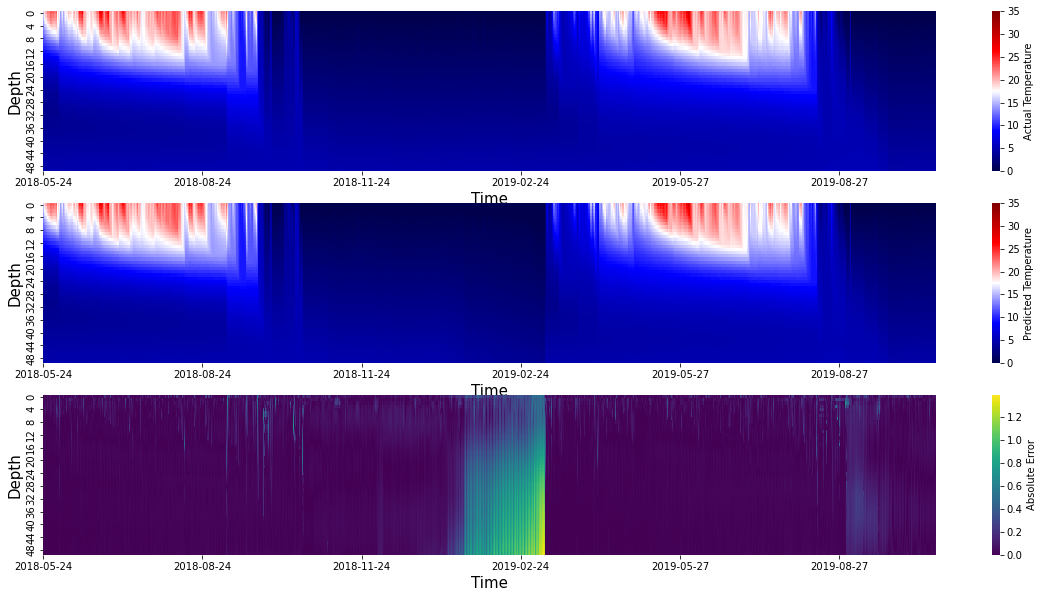

In [26]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

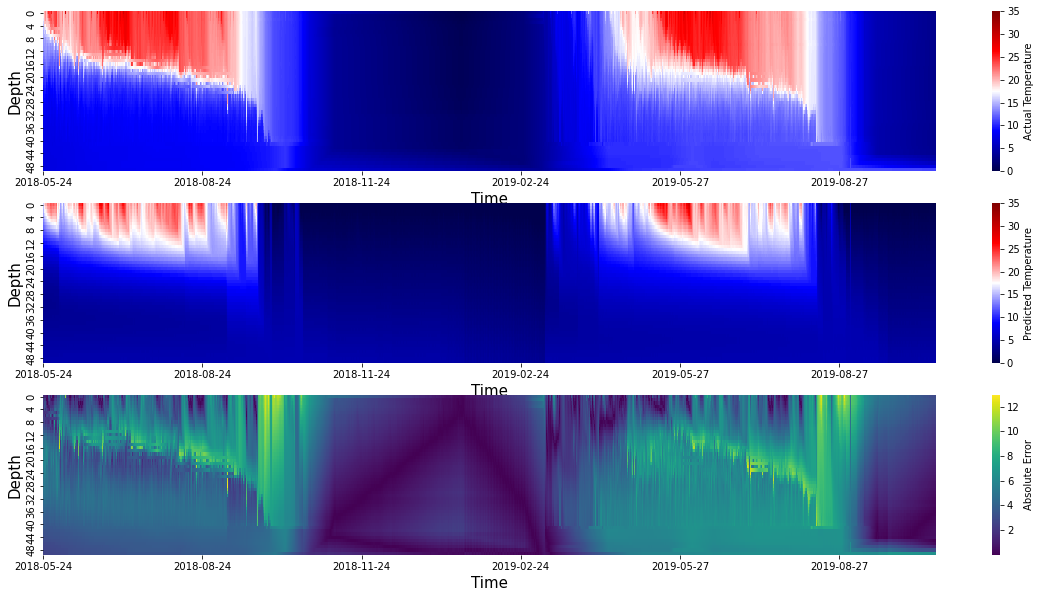

In [27]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [28]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.03782955638740216, Train L2 Error: 0.005268838962665684
Test RMSE: 0.18678504973751686, Train L2 Error: 0.022802347999341492


## Mixing Model

## Convection Model

In [29]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.015869904177310025, Train L2 Error: 0.0022104449320295414
Test RMSE: 0.037338841131498976, Train L2 Error: 0.004558462990788645


## Ice Model

In [30]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.011916424143528238, Train L2 Error: 0.0016585208599914363
Test RMSE: 0.07897739329873596, Train L2 Error: 0.0096342043173161


# Finetuning

In [31]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [32]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [33]:
#freeze_model(heating_model)
freeze_model(heating_model)
unfreeze_model(heat_diff_model)
freeze_model(convection_model)
freeze_model(ice_model)


# Finetuning on Observed Temperature

In [34]:
heating_model.train()
heat_diff_model.train()
convection_model.train()
ice_model.train()

n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out3 = torch.tensor(train_mean[m3_output_column_ix[0]]).float().to(device)
std_out3 = torch.tensor(train_std[m3_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        m4_pred = ice_model(m4_input)
        loss_m4 = criterion(m4_pred, x[:, m4_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)

        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out3)/std_out3
        
        loss_m3 = criterion(m3_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m3
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]},  Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/1000 [00:08<2:18:19,  8.31s/it]

Epoch : 0, Train_loss: 0.8789751806930274, Loss m0: 3.55258023806422e-06, Loss m1: 0.007487282864117039,  Loss m3: 0.8789751806930274, Loss m4: 9.694443548180119e-06


  5%|▌         | 51/1000 [07:08<2:04:49,  7.89s/it]

Epoch : 50, Train_loss: 0.09244971502569642, Loss m0: 3.55258023806422e-06, Loss m1: 0.8977912628435364,  Loss m3: 0.09244971502569642, Loss m4: 9.694443548180119e-06


 10%|█         | 101/1000 [13:53<2:03:38,  8.25s/it]

Epoch : 100, Train_loss: 0.07840157488180402, Loss m0: 3.55258023806422e-06, Loss m1: 0.9159872465175595,  Loss m3: 0.07840157488180402, Loss m4: 9.694443548180119e-06


 15%|█▌        | 151/1000 [20:38<1:52:34,  7.96s/it]

Epoch : 150, Train_loss: 0.06967940375714797, Loss m0: 3.55258023806422e-06, Loss m1: 0.924866706727802,  Loss m3: 0.06967940375714797, Loss m4: 9.694443548180119e-06


 20%|██        | 201/1000 [27:18<1:48:07,  8.12s/it]

Epoch : 200, Train_loss: 0.06305416265669449, Loss m0: 3.55258023806422e-06, Loss m1: 0.9330034756735534,  Loss m3: 0.06305416265669449, Loss m4: 9.694443548180119e-06


 25%|██▌       | 251/1000 [34:15<1:45:44,  8.47s/it]

Epoch : 250, Train_loss: 0.058279632662862055, Loss m0: 3.55258023806422e-06, Loss m1: 0.9398671908325342,  Loss m3: 0.058279632662862055, Loss m4: 9.694443548180119e-06


 30%|███       | 301/1000 [41:12<1:36:35,  8.29s/it]

Epoch : 300, Train_loss: 0.055037658963265686, Loss m0: 3.55258023806422e-06, Loss m1: 0.9451471833165154,  Loss m3: 0.055037658963265686, Loss m4: 9.694443548180119e-06


 35%|███▌      | 351/1000 [48:03<1:26:36,  8.01s/it]

Epoch : 350, Train_loss: 0.0527451965345261, Loss m0: 3.55258023806422e-06, Loss m1: 0.9488740730623471,  Loss m3: 0.0527451965345261, Loss m4: 9.694443548180119e-06


 40%|████      | 401/1000 [54:43<1:19:15,  7.94s/it]

Epoch : 400, Train_loss: 0.050923598846579994, Loss m0: 3.55258023806422e-06, Loss m1: 0.951455574404774,  Loss m3: 0.050923598846579994, Loss m4: 9.694443548180119e-06


 45%|████▌     | 451/1000 [1:01:25<1:13:32,  8.04s/it]

Epoch : 450, Train_loss: 0.04935095259590436, Loss m0: 3.55258023806422e-06, Loss m1: 0.9534141474435311,  Loss m3: 0.04935095259590436, Loss m4: 9.694443548180119e-06


 50%|█████     | 501/1000 [1:08:05<1:06:46,  8.03s/it]

Epoch : 500, Train_loss: 0.047942982221680905, Loss m0: 3.55258023806422e-06, Loss m1: 0.9550682244301834,  Loss m3: 0.047942982221680905, Loss m4: 9.694443548180119e-06


 55%|█████▌    | 551/1000 [1:14:57<1:01:01,  8.15s/it]

Epoch : 550, Train_loss: 0.04665588228848228, Loss m0: 3.55258023806422e-06, Loss m1: 0.9565557864345894,  Loss m3: 0.04665588228848228, Loss m4: 9.694443548180119e-06


 60%|██████    | 601/1000 [1:22:03<1:03:04,  9.49s/it]

Epoch : 600, Train_loss: 0.0454663515640706, Loss m0: 3.55258023806422e-06, Loss m1: 0.9579086764379202,  Loss m3: 0.0454663515640706, Loss m4: 9.694443548180119e-06


 65%|██████▌   | 651/1000 [1:29:38<49:31,  8.51s/it]  

Epoch : 650, Train_loss: 0.04436394500306244, Loss m0: 3.55258023806422e-06, Loss m1: 0.9591353671030344,  Loss m3: 0.04436394500306244, Loss m4: 9.694443548180119e-06


 70%|███████   | 701/1000 [1:37:06<45:52,  9.20s/it]

Epoch : 700, Train_loss: 0.043341059153173614, Loss m0: 3.55258023806422e-06, Loss m1: 0.9602592784199623,  Loss m3: 0.043341059153173614, Loss m4: 9.694443548180119e-06


 75%|███████▌  | 751/1000 [1:43:04<26:29,  6.38s/it]

Epoch : 750, Train_loss: 0.042390526966643326, Loss m0: 3.55258023806422e-06, Loss m1: 0.9612975191473677,  Loss m3: 0.042390526966643326, Loss m4: 9.694443548180119e-06


 80%|████████  | 801/1000 [1:48:26<21:32,  6.50s/it]

Epoch : 800, Train_loss: 0.04150506029124177, Loss m0: 3.55258023806422e-06, Loss m1: 0.9622661820488908,  Loss m3: 0.04150506029124177, Loss m4: 9.694443548180119e-06


 85%|████████▌ | 851/1000 [1:53:46<15:24,  6.20s/it]

Epoch : 850, Train_loss: 0.04067805661384314, Loss m0: 3.55258023806422e-06, Loss m1: 0.9631732857410757,  Loss m3: 0.04067805661384314, Loss m4: 9.694443548180119e-06


 90%|█████████ | 901/1000 [1:59:14<12:39,  7.67s/it]

Epoch : 900, Train_loss: 0.03990427025750071, Loss m0: 3.55258023806422e-06, Loss m1: 0.9640277279629426,  Loss m3: 0.03990427025750071, Loss m4: 9.694443548180119e-06


 95%|█████████▌| 951/1000 [2:04:38<05:01,  6.15s/it]

Epoch : 950, Train_loss: 0.03917869734741613, Loss m0: 3.55258023806422e-06, Loss m1: 0.9648368567858642,  Loss m3: 0.03917869734741613, Loss m4: 9.694443548180119e-06


100%|██████████| 1000/1000 [2:09:42<00:00,  7.78s/it]


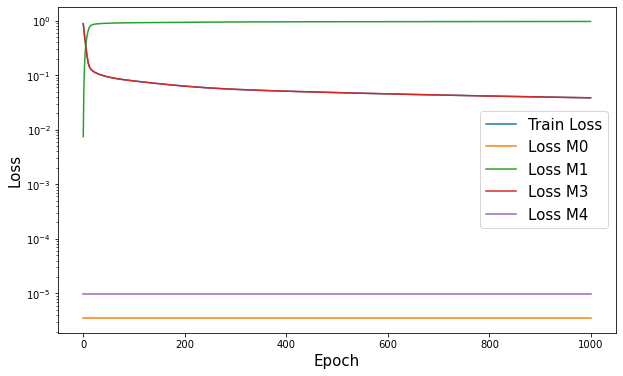

In [35]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
#plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [36]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0041027484
RMSE of after m1 0.016025735
RMSE of after m3 5.738612
RMSE of after m4 5.730834
RMSE of after m0 0.006662367
RMSE of after m1 0.052950934
RMSE of after m3 4.3749695
RMSE of after m4 4.38033
RMSE of after m0 0.008104843
RMSE of after m1 0.028474016
RMSE of after m3 3.3445947
RMSE of after m4 3.3495994
RMSE of after m0 0.0076912576
RMSE of after m1 0.020512382
RMSE of after m3 2.8195643
RMSE of after m4 2.8164294
RMSE of after m0 0.007948776
RMSE of after m1 0.018048972
RMSE of after m3 2.8533645
RMSE of after m4 2.849952
RMSE of after m0 0.007042731
RMSE of after m1 0.015575844
RMSE of after m3 2.8396583
RMSE of after m4 2.8359525
RMSE of after m0 0.005781268
RMSE of after m1 0.013841938
RMSE of after m3 2.81648
RMSE of after m4 2.812994
RMSE of after m0 0.008311805
RMSE of after m1 0.018056948
RMSE of after m3 2.7887518
RMSE of after m4 2.785541
RMSE of after m0 0.0074767084
RMSE of after m1 0.014158648
RMSE of after m3 2.877305
RMSE of after m4 2.8739903

RMSE of after m1 0.021060318
RMSE of after m3 3.410974
RMSE of after m4 3.3810644
RMSE of after m0 0.008016883
RMSE of after m1 0.013012053
RMSE of after m3 3.0594878
RMSE of after m4 3.0429854
RMSE of after m0 0.007719434
RMSE of after m1 0.012428046
RMSE of after m3 3.0496714
RMSE of after m4 3.0344965
RMSE of after m0 0.0071564387
RMSE of after m1 0.012428943
RMSE of after m3 3.071743
RMSE of after m4 3.0577893
RMSE of after m0 0.007300024
RMSE of after m1 0.010379379
RMSE of after m3 3.0913985
RMSE of after m4 3.0772884
RMSE of after m0 0.0075153084
RMSE of after m1 0.010424047
RMSE of after m3 3.1151338
RMSE of after m4 3.1004815
RMSE of after m0 0.009560194
RMSE of after m1 0.013463398
RMSE of after m3 3.1889408
RMSE of after m4 3.172033
RMSE of after m0 0.0106610805
RMSE of after m1 0.009391525
RMSE of after m3 3.1140296
RMSE of after m4 3.0964239
RMSE of after m0 0.0063750176
RMSE of after m1 0.01444304
RMSE of after m3 2.9972177
RMSE of after m4 2.9802175
RMSE of after m0 0.00

RMSE of after m1 0.006769117
RMSE of after m3 4.8195047
RMSE of after m4 4.7934875
RMSE of after m0 0.0053658145
RMSE of after m1 0.0065745227
RMSE of after m3 4.8183403
RMSE of after m4 4.791322
RMSE of after m0 0.0063717933
RMSE of after m1 0.0074208993
RMSE of after m3 4.852075
RMSE of after m4 4.824004
RMSE of after m0 0.0055102794
RMSE of after m1 0.006681906
RMSE of after m3 4.8654537
RMSE of after m4 4.8360662
RMSE of after m0 0.005145714
RMSE of after m1 0.006216029
RMSE of after m3 4.9513993
RMSE of after m4 4.921007
RMSE of after m0 0.0053846324
RMSE of after m1 0.006065296
RMSE of after m3 4.9189916
RMSE of after m4 4.8897834
RMSE of after m0 0.0053873393
RMSE of after m1 0.0056411745
RMSE of after m3 4.83148
RMSE of after m4 4.802288
RMSE of after m0 0.0046805115
RMSE of after m1 0.0054209875
RMSE of after m3 4.8059115
RMSE of after m4 4.775353
RMSE of after m0 0.004866349
RMSE of after m1 0.0058983197
RMSE of after m3 4.8326283
RMSE of after m4 4.8011684
RMSE of after m0 0

RMSE of after m1 0.006811052
RMSE of after m3 6.840389
RMSE of after m4 6.7905765
RMSE of after m0 0.0049668686
RMSE of after m1 0.0065088267
RMSE of after m3 6.794125
RMSE of after m4 6.7419906
RMSE of after m0 0.0056719612
RMSE of after m1 0.0066433423
RMSE of after m3 6.81993
RMSE of after m4 6.7655787
RMSE of after m0 0.007716237
RMSE of after m1 0.008502221
RMSE of after m3 6.9226646
RMSE of after m4 6.865478
RMSE of after m0 0.008795654
RMSE of after m1 0.0088273445
RMSE of after m3 6.9378414
RMSE of after m4 6.8797107
RMSE of after m0 0.005982021
RMSE of after m1 0.006701833
RMSE of after m3 6.915799
RMSE of after m4 6.8628893
RMSE of after m0 0.006553105
RMSE of after m1 0.0069946493
RMSE of after m3 6.958467
RMSE of after m4 6.9100146
RMSE of after m0 0.005769357
RMSE of after m1 0.0067615686
RMSE of after m3 6.91396
RMSE of after m4 6.8636284
RMSE of after m0 0.0045760926
RMSE of after m1 0.005928934
RMSE of after m3 6.950587
RMSE of after m4 6.897594
RMSE of after m0 0.00477

RMSE of after m4 7.351762
RMSE of after m0 0.020443358
RMSE of after m1 0.021180231
RMSE of after m3 6.8607564
RMSE of after m4 6.8303404
RMSE of after m0 0.006188447
RMSE of after m1 0.0077476916
RMSE of after m3 6.524969
RMSE of after m4 6.491557
RMSE of after m0 0.0077178576
RMSE of after m1 0.008949311
RMSE of after m3 6.4473996
RMSE of after m4 6.4138145
RMSE of after m0 0.007821429
RMSE of after m1 0.009453861
RMSE of after m3 6.154153
RMSE of after m4 6.1204114
RMSE of after m0 0.009254801
RMSE of after m1 0.01033398
RMSE of after m3 6.2022715
RMSE of after m4 6.166631
RMSE of after m0 0.00526814
RMSE of after m1 0.007324112
RMSE of after m3 6.3638496
RMSE of after m4 6.3275614
RMSE of after m0 0.007524586
RMSE of after m1 0.008904977
RMSE of after m3 6.549319
RMSE of after m4 6.5212846
RMSE of after m0 0.0063244603
RMSE of after m1 0.008631524
RMSE of after m3 6.961179
RMSE of after m4 6.9392834
RMSE of after m0 0.0049206377
RMSE of after m1 0.007207069
RMSE of after m3 7.06704

RMSE of after m3 3.8400612
RMSE of after m4 3.841716
RMSE of after m0 0.0066463603
RMSE of after m1 0.010149479
RMSE of after m3 3.7445061
RMSE of after m4 3.7462113
RMSE of after m0 0.006775314
RMSE of after m1 0.00914657
RMSE of after m3 3.70218
RMSE of after m4 3.7040246
RMSE of after m0 0.0066165403
RMSE of after m1 0.007919678
RMSE of after m3 3.6034641
RMSE of after m4 3.6044807
RMSE of after m0 0.006344608
RMSE of after m1 0.01426713
RMSE of after m3 3.6030555
RMSE of after m4 3.6019742
RMSE of after m0 0.0063062613
RMSE of after m1 0.016211433
RMSE of after m3 3.454073
RMSE of after m4 3.4530976
RMSE of after m0 0.00935347
RMSE of after m1 0.006502617
RMSE of after m3 3.308843
RMSE of after m4 3.3072019
RMSE of after m0 0.0072705667
RMSE of after m1 0.0070273904
RMSE of after m3 3.2336423
RMSE of after m4 3.2302403
RMSE of after m0 0.0065613766
RMSE of after m1 0.006753407
RMSE of after m3 3.3780174
RMSE of after m4 3.3752055
RMSE of after m0 0.0065200236
RMSE of after m1 0.006

RMSE of after m1 0.02229774
RMSE of after m3 1.8869869
RMSE of after m4 1.8385513
RMSE of after m0 0.022074383
RMSE of after m1 0.023223592
RMSE of after m3 2.0225213
RMSE of after m4 1.9674857
RMSE of after m0 0.07193749
RMSE of after m1 0.038473647
RMSE of after m3 2.2320638
RMSE of after m4 2.1627579
RMSE of after m0 0.010103117
RMSE of after m1 0.02328123
RMSE of after m3 2.6657178
RMSE of after m4 2.577365
RMSE of after m0 0.0075243246
RMSE of after m1 0.023698889
RMSE of after m3 2.4747555
RMSE of after m4 2.3932292
RMSE of after m0 0.011608409
RMSE of after m1 0.026273083
RMSE of after m3 2.8621352
RMSE of after m4 2.6704612
RMSE of after m0 0.01310352
RMSE of after m1 0.026367104
RMSE of after m3 2.6421502
RMSE of after m4 2.4641123
RMSE of after m0 0.013047821
RMSE of after m1 0.025047049
RMSE of after m3 2.816022
RMSE of after m4 2.6239626
RMSE of after m0 0.012503609
RMSE of after m1 0.025764495
RMSE of after m3 2.91016
RMSE of after m4 2.7084908
RMSE of after m0 0.010975656

RMSE of after m1 0.013325183
RMSE of after m3 3.9213357
RMSE of after m4 3.8859363
RMSE of after m0 0.0061227325
RMSE of after m1 0.0070646657
RMSE of after m3 3.8681462
RMSE of after m4 3.8300269
RMSE of after m0 0.007161075
RMSE of after m1 0.006997032
RMSE of after m3 3.691031
RMSE of after m4 3.6569436
RMSE of after m0 0.010816187
RMSE of after m1 0.010440025
RMSE of after m3 3.9381716
RMSE of after m4 3.9032166
RMSE of after m0 0.0039694514
RMSE of after m1 0.00503763
RMSE of after m3 4.640433
RMSE of after m4 4.610893
RMSE of after m0 0.00784866
RMSE of after m1 0.009252726
RMSE of after m3 4.7183213
RMSE of after m4 4.685122
RMSE of after m0 0.0054248995
RMSE of after m1 0.0065187598
RMSE of after m3 4.5655856
RMSE of after m4 4.5286903
RMSE of after m0 0.0076750508
RMSE of after m1 0.008601669
RMSE of after m3 4.594715
RMSE of after m4 4.5563674
RMSE of after m0 0.003457925
RMSE of after m1 0.0036210304
RMSE of after m3 4.2673416
RMSE of after m4 4.23374
RMSE of after m0 0.0039

RMSE of after m1 0.0084810965
RMSE of after m3 6.3010716
RMSE of after m4 6.2313147
RMSE of after m0 0.0045933505
RMSE of after m1 0.005498351
RMSE of after m3 6.2235894
RMSE of after m4 6.161671
RMSE of after m0 0.0068520634
RMSE of after m1 0.0070947884
RMSE of after m3 6.2906938
RMSE of after m4 6.226007
RMSE of after m0 0.0055904794
RMSE of after m1 0.0065575787
RMSE of after m3 6.225105
RMSE of after m4 6.1610723
RMSE of after m0 0.0051715537
RMSE of after m1 0.006703317
RMSE of after m3 6.1250668
RMSE of after m4 6.060529
RMSE of after m0 0.0043952074
RMSE of after m1 0.006380755
RMSE of after m3 6.1562343
RMSE of after m4 6.0891232
RMSE of after m0 0.0040559755
RMSE of after m1 0.006288794
RMSE of after m3 6.0610948
RMSE of after m4 5.99377
RMSE of after m0 0.0046410873
RMSE of after m1 0.005774327
RMSE of after m3 6.129033
RMSE of after m4 6.068987
RMSE of after m0 0.0045433035
RMSE of after m1 0.0063921576
RMSE of after m3 6.077934
RMSE of after m4 6.0153317
RMSE of after m0 0

RMSE of after m1 0.0072951196
RMSE of after m3 6.0952067
RMSE of after m4 6.041472
RMSE of after m0 0.0055734883
RMSE of after m1 0.0067326976
RMSE of after m3 6.134671
RMSE of after m4 6.0807114
RMSE of after m0 0.0048967497
RMSE of after m1 0.0062009185
RMSE of after m3 6.177189
RMSE of after m4 6.1233163
RMSE of after m0 0.0061120098
RMSE of after m1 0.0064613237
RMSE of after m3 6.446167
RMSE of after m4 6.4061694
RMSE of after m0 0.0051231743
RMSE of after m1 0.0064375233
RMSE of after m3 6.7132874
RMSE of after m4 6.6729755
RMSE of after m0 0.0048861536
RMSE of after m1 0.0065303803
RMSE of after m3 6.6177373
RMSE of after m4 6.5722675
RMSE of after m0 0.0053907027
RMSE of after m1 0.006697183
RMSE of after m3 6.4565306
RMSE of after m4 6.40922
RMSE of after m0 0.005444892
RMSE of after m1 0.006734252
RMSE of after m3 6.3886585
RMSE of after m4 6.3403716
RMSE of after m0 0.005294956
RMSE of after m1 0.0067568254
RMSE of after m3 6.3365407
RMSE of after m4 6.287569
RMSE of after m

RMSE of after m1 0.011876333
RMSE of after m3 1.9231769
RMSE of after m4 1.9570245
RMSE of after m0 0.0067348643
RMSE of after m1 0.019396625
RMSE of after m3 1.8496588
RMSE of after m4 1.8822933
RMSE of after m0 0.0067455457
RMSE of after m1 0.017557483
RMSE of after m3 1.5795121
RMSE of after m4 1.6100376
RMSE of after m0 0.0062223696
RMSE of after m1 0.010954121
RMSE of after m3 1.3918175
RMSE of after m4 1.4218311
RMSE of after m0 0.006177346
RMSE of after m1 0.01058761
RMSE of after m3 1.5203046
RMSE of after m4 1.5505545
RMSE of after m0 0.0066423966
RMSE of after m1 0.012651262
RMSE of after m3 1.556118
RMSE of after m4 1.5861709
RMSE of after m0 0.0060800286
RMSE of after m1 0.009504572
RMSE of after m3 1.2852579
RMSE of after m4 1.314395
RMSE of after m0 0.0061832014
RMSE of after m1 0.008709531
RMSE of after m3 1.3750964
RMSE of after m4 1.4039923
RMSE of after m0 0.0058780992
RMSE of after m1 0.0105194235
RMSE of after m3 1.1665353
RMSE of after m4 1.1948096
RMSE of after m0

RMSE of after m1 0.020294625
RMSE of after m3 1.1133434
RMSE of after m4 1.1115732
RMSE of after m0 0.011730438
RMSE of after m1 0.019882299
RMSE of after m3 1.0974098
RMSE of after m4 1.0934161
RMSE of after m0 0.0110726105
RMSE of after m1 0.019797077
RMSE of after m3 1.1189367
RMSE of after m4 1.1145163
RMSE of after m0 0.011799499
RMSE of after m1 0.02032456
RMSE of after m3 1.1163143
RMSE of after m4 1.1135433
RMSE of after m0 0.013557941
RMSE of after m1 0.022874724
RMSE of after m3 1.115531
RMSE of after m4 1.1131722
RMSE of after m0 0.012712338
RMSE of after m1 0.020918265
RMSE of after m3 1.1220117
RMSE of after m4 1.1205225
RMSE of after m0 0.013270841
RMSE of after m1 0.02414856
RMSE of after m3 1.1124206
RMSE of after m4 1.1111568
RMSE of after m0 0.011779894
RMSE of after m1 0.020329226
RMSE of after m3 1.1206409
RMSE of after m4 1.1195492
RMSE of after m0 0.011906551
RMSE of after m1 0.021817118
RMSE of after m3 1.1334554
RMSE of after m4 1.1324203
RMSE of after m0 0.0115

RMSE of after m1 0.026675934
RMSE of after m3 6.1375165
RMSE of after m4 6.012797
RMSE of after m0 0.018475292
RMSE of after m1 0.022742009
RMSE of after m3 6.177713
RMSE of after m4 6.057608
RMSE of after m0 0.020782286
RMSE of after m1 0.022745833
RMSE of after m3 4.9185805
RMSE of after m4 4.9017324
RMSE of after m0 0.009787262
RMSE of after m1 0.011327218
RMSE of after m3 4.5657783
RMSE of after m4 4.546329
RMSE of after m0 0.0053972024
RMSE of after m1 0.007936059
RMSE of after m3 4.362414
RMSE of after m4 4.342265
RMSE of after m0 0.0059422017
RMSE of after m1 0.0075063827
RMSE of after m3 4.237584
RMSE of after m4 4.216802
RMSE of after m0 0.0074647646
RMSE of after m1 0.008258566
RMSE of after m3 4.185396
RMSE of after m4 4.1633835
RMSE of after m0 0.005196498
RMSE of after m1 0.0056626503
RMSE of after m3 4.200723
RMSE of after m4 4.178005
RMSE of after m0 0.0051579773
RMSE of after m1 0.0058553712
RMSE of after m3 4.429683
RMSE of after m4 4.407128
RMSE of after m0 0.00684121

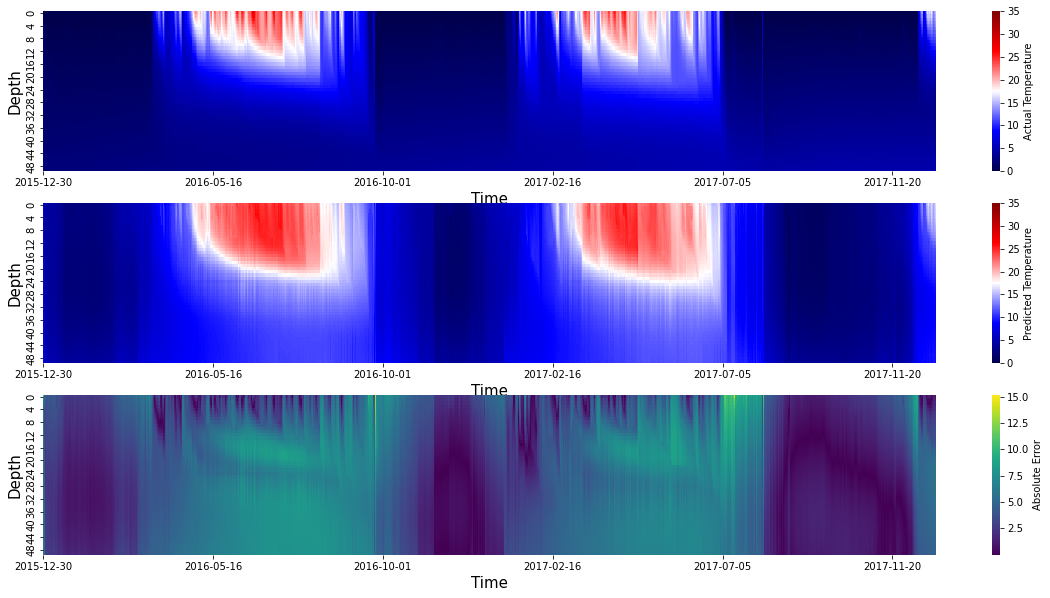

In [37]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

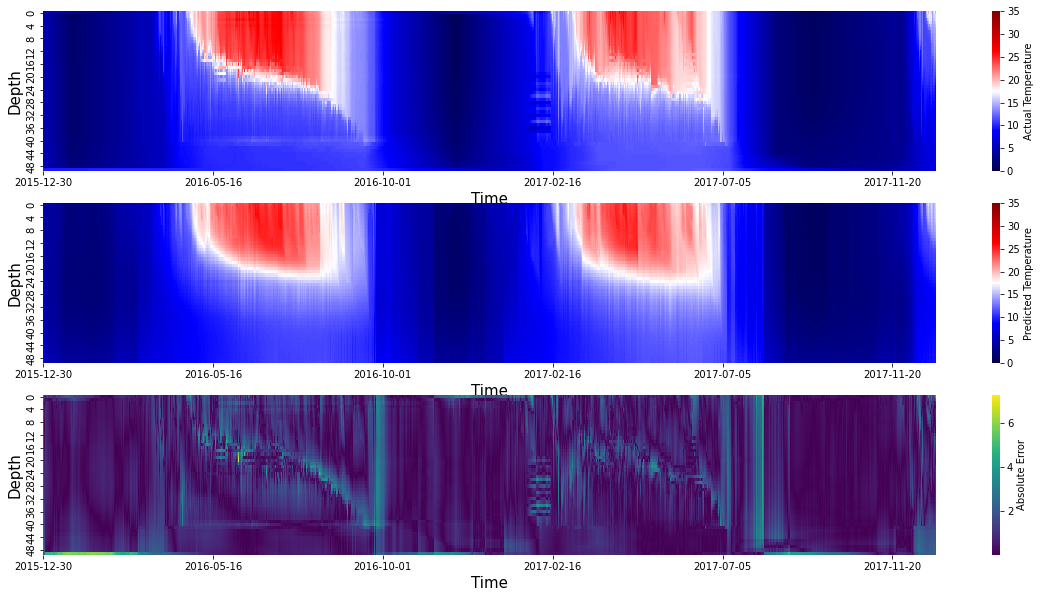

In [38]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [39]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0059419116
RMSE of after m1 0.006902804
RMSE of after m3 4.736997
RMSE of after m4 4.707111
RMSE of after m0 0.007157667
RMSE of after m1 0.007972541
RMSE of after m3 4.7862415
RMSE of after m4 4.7569647
RMSE of after m0 0.0047542206
RMSE of after m1 0.005939046
RMSE of after m3 4.7394423
RMSE of after m4 4.710184
RMSE of after m0 0.0051618326
RMSE of after m1 0.0064778053
RMSE of after m3 4.755626
RMSE of after m4 4.72573
RMSE of after m0 0.005379781
RMSE of after m1 0.006945205
RMSE of after m3 4.7981777
RMSE of after m4 4.7674537
RMSE of after m0 0.005166138
RMSE of after m1 0.00688493
RMSE of after m3 4.8483286
RMSE of after m4 4.816553
RMSE of after m0 0.005269972
RMSE of after m1 0.0065093883
RMSE of after m3 4.948486
RMSE of after m4 4.9168286
RMSE of after m0 0.0053153355
RMSE of after m1 0.006314988
RMSE of after m3 5.0065293
RMSE of after m4 4.975632
RMSE of after m0 0.0046447846
RMSE of after m1 0.005735461
RMSE of after m3 5.029772
RMSE of after m4 4.9980

RMSE of after m3 6.8383365
RMSE of after m4 6.783969
RMSE of after m0 0.004651336
RMSE of after m1 0.0052186395
RMSE of after m3 6.9050746
RMSE of after m4 6.8484626
RMSE of after m0 0.006738399
RMSE of after m1 0.006307005
RMSE of after m3 7.1583652
RMSE of after m4 7.098611
RMSE of after m0 0.0045562373
RMSE of after m1 0.0053185276
RMSE of after m3 7.1718607
RMSE of after m4 7.1135364
RMSE of after m0 0.004400697
RMSE of after m1 0.0052654603
RMSE of after m3 6.9073853
RMSE of after m4 6.855473
RMSE of after m0 0.004251443
RMSE of after m1 0.005222451
RMSE of after m3 6.764824
RMSE of after m4 6.71553
RMSE of after m0 0.0042958637
RMSE of after m1 0.005340063
RMSE of after m3 6.7363534
RMSE of after m4 6.684468
RMSE of after m0 0.004362774
RMSE of after m1 0.005513797
RMSE of after m3 6.7501836
RMSE of after m4 6.696066
RMSE of after m0 0.004997493
RMSE of after m1 0.0059960084
RMSE of after m3 6.74971
RMSE of after m4 6.694248
RMSE of after m0 0.004648825
RMSE of after m1 0.0054050

RMSE of after m3 6.7187076
RMSE of after m4 6.672971
RMSE of after m0 0.014217554
RMSE of after m1 0.015251122
RMSE of after m3 6.3230915
RMSE of after m4 6.27313
RMSE of after m0 0.0077482862
RMSE of after m1 0.009078389
RMSE of after m3 6.251015
RMSE of after m4 6.199824
RMSE of after m0 0.013241572
RMSE of after m1 0.013726204
RMSE of after m3 6.0657597
RMSE of after m4 6.013344
RMSE of after m0 0.020242635
RMSE of after m1 0.020889586
RMSE of after m3 7.2305093
RMSE of after m4 7.20144
RMSE of after m0 0.0053321305
RMSE of after m1 0.006537798
RMSE of after m3 7.971513
RMSE of after m4 7.9439197
RMSE of after m0 0.005444714
RMSE of after m1 0.00560691
RMSE of after m3 8.043441
RMSE of after m4 8.011615
RMSE of after m0 0.0048649157
RMSE of after m1 0.0047935587
RMSE of after m3 8.039495
RMSE of after m4 8.003326
RMSE of after m0 0.0054496257
RMSE of after m1 0.005318257
RMSE of after m3 7.9746485
RMSE of after m4 7.9400835
RMSE of after m0 0.004818744
RMSE of after m1 0.009874662
R

RMSE of after m1 0.025849689
RMSE of after m3 3.8979166
RMSE of after m4 3.9278781
RMSE of after m0 0.006125655
RMSE of after m1 0.027510893
RMSE of after m3 3.803583
RMSE of after m4 3.83365
RMSE of after m0 0.0057877405
RMSE of after m1 0.025509985
RMSE of after m3 3.8503833
RMSE of after m4 3.8803802
RMSE of after m0 0.006058096
RMSE of after m1 0.02867517
RMSE of after m3 3.7448924
RMSE of after m4 3.7742693
RMSE of after m0 0.0060550757
RMSE of after m1 0.037306633
RMSE of after m3 3.668538
RMSE of after m4 3.6971016
RMSE of after m0 0.006025307
RMSE of after m1 0.045151796
RMSE of after m3 3.5211103
RMSE of after m4 3.5483599
RMSE of after m0 0.0059521864
RMSE of after m1 0.041836157
RMSE of after m3 3.2956178
RMSE of after m4 3.3215642
RMSE of after m0 0.005937947
RMSE of after m1 0.029474173
RMSE of after m3 3.183737
RMSE of after m4 3.2096655
RMSE of after m0 0.0062816683
RMSE of after m1 0.027751928
RMSE of after m3 3.3789186
RMSE of after m4 3.4066238
RMSE of after m0 0.0057

RMSE of after m1 0.20430648
RMSE of after m3 1.3178065
RMSE of after m4 1.2368543
RMSE of after m0 0.048772503
RMSE of after m1 0.20269486
RMSE of after m3 1.4207665
RMSE of after m4 1.3443007
RMSE of after m0 0.057070404
RMSE of after m1 0.22015743
RMSE of after m3 1.691864
RMSE of after m4 1.611327
RMSE of after m0 0.081837445
RMSE of after m1 0.21378964
RMSE of after m3 1.7262768
RMSE of after m4 1.6393731
RMSE of after m0 0.08383038
RMSE of after m1 0.21712008
RMSE of after m3 1.7583795
RMSE of after m4 1.6703151
RMSE of after m0 0.07358685
RMSE of after m1 0.22259748
RMSE of after m3 1.9049342
RMSE of after m4 1.8198719
RMSE of after m0 0.06884054
RMSE of after m1 0.22575627
RMSE of after m3 1.6744246
RMSE of after m4 1.5893197
RMSE of after m0 0.06593164
RMSE of after m1 0.22944355
RMSE of after m3 1.6287705
RMSE of after m4 1.543371
RMSE of after m0 0.058176953
RMSE of after m1 0.22309679
RMSE of after m3 1.3675007
RMSE of after m4 1.284329
RMSE of after m0 0.05369765
RMSE of af

RMSE of after m1 0.005027642
RMSE of after m3 4.0153995
RMSE of after m4 3.995607
RMSE of after m0 0.0050406186
RMSE of after m1 0.0059503946
RMSE of after m3 4.0110507
RMSE of after m4 3.9901981
RMSE of after m0 0.004737943
RMSE of after m1 0.0058847843
RMSE of after m3 4.0240493
RMSE of after m4 4.0019517
RMSE of after m0 0.003634172
RMSE of after m1 0.0057067676
RMSE of after m3 3.9563856
RMSE of after m4 3.93518
RMSE of after m0 0.0070990403
RMSE of after m1 0.009100977
RMSE of after m3 3.9714088
RMSE of after m4 3.9495082
RMSE of after m0 0.0065198527
RMSE of after m1 0.008089203
RMSE of after m3 3.8530257
RMSE of after m4 3.8297408
RMSE of after m0 0.0041591725
RMSE of after m1 0.005249837
RMSE of after m3 3.857145
RMSE of after m4 3.8331044
RMSE of after m0 0.0043973597
RMSE of after m1 0.0054759462
RMSE of after m3 4.038919
RMSE of after m4 4.0150285
RMSE of after m0 0.009804414
RMSE of after m1 0.010790948
RMSE of after m3 4.228091
RMSE of after m4 4.2062845
RMSE of after m0 0

RMSE of after m1 0.0059934855
RMSE of after m3 5.728559
RMSE of after m4 5.6728234
RMSE of after m0 0.006143614
RMSE of after m1 0.006643497
RMSE of after m3 5.681837
RMSE of after m4 5.625407
RMSE of after m0 0.009129685
RMSE of after m1 0.00869524
RMSE of after m3 6.1031528
RMSE of after m4 6.0403028
RMSE of after m0 0.005989729
RMSE of after m1 0.006514954
RMSE of after m3 6.0889378
RMSE of after m4 6.027927
RMSE of after m0 0.004347967
RMSE of after m1 0.005534101
RMSE of after m3 5.7608504
RMSE of after m4 5.7108645
RMSE of after m0 0.008546056
RMSE of after m1 0.0084112855
RMSE of after m3 6.1708846
RMSE of after m4 6.115132
RMSE of after m0 0.007718916
RMSE of after m1 0.008493298
RMSE of after m3 6.217862
RMSE of after m4 6.157231
RMSE of after m0 0.007579676
RMSE of after m1 0.0071668206
RMSE of after m3 6.262969
RMSE of after m4 6.198653
RMSE of after m0 0.0052153342
RMSE of after m1 0.0059562083
RMSE of after m3 6.174797
RMSE of after m4 6.1119404
RMSE of after m0 0.00495172

RMSE of after m0 0.0047559226
RMSE of after m1 0.005867533
RMSE of after m3 6.8996444
RMSE of after m4 6.840996
RMSE of after m0 0.0043572993
RMSE of after m1 0.0063660378
RMSE of after m3 6.995415
RMSE of after m4 6.9360704
RMSE of after m0 0.009541761
RMSE of after m1 0.0105675645
RMSE of after m3 6.965073
RMSE of after m4 6.9007874
RMSE of after m0 0.010652665
RMSE of after m1 0.011332962
RMSE of after m3 6.782993
RMSE of after m4 6.7169003
RMSE of after m0 0.0062764497
RMSE of after m1 0.0069491398
RMSE of after m3 6.6318297
RMSE of after m4 6.5769696
RMSE of after m0 0.0070268344
RMSE of after m1 0.0077662654
RMSE of after m3 6.686626
RMSE of after m4 6.6288476
RMSE of after m0 0.0076765288
RMSE of after m1 0.00815065
RMSE of after m3 6.700615
RMSE of after m4 6.6396046
RMSE of after m0 0.009303762
RMSE of after m1 0.008746632
RMSE of after m3 6.744418
RMSE of after m4 6.6828427
RMSE of after m0 0.0052251164
RMSE of after m1 0.006497073
RMSE of after m3 6.7593093
RMSE of after m4 

RMSE of after m3 5.8532248
RMSE of after m4 5.843516
RMSE of after m0 0.005460474
RMSE of after m1 0.11758058
RMSE of after m3 5.7412477
RMSE of after m4 5.7349906
RMSE of after m0 0.005135499
RMSE of after m1 0.117394194
RMSE of after m3 5.742554
RMSE of after m4 5.737111
RMSE of after m0 0.0062260786
RMSE of after m1 0.119748704
RMSE of after m3 5.4201536
RMSE of after m4 5.4110026
RMSE of after m0 0.009774965
RMSE of after m1 0.09839844
RMSE of after m3 5.2028317
RMSE of after m4 5.186758
RMSE of after m0 0.00991385
RMSE of after m1 0.09587604
RMSE of after m3 5.3164754
RMSE of after m4 5.2997785
RMSE of after m0 0.008737732
RMSE of after m1 0.08878667
RMSE of after m3 5.2042093
RMSE of after m4 5.1908493
RMSE of after m0 0.0068173544
RMSE of after m1 0.08657073
RMSE of after m3 5.385845
RMSE of after m4 5.373893
RMSE of after m0 0.006855696
RMSE of after m1 0.086653516
RMSE of after m3 5.303748
RMSE of after m4 5.2945232
RMSE of after m0 0.0064499695
RMSE of after m1 0.08633532
RMS

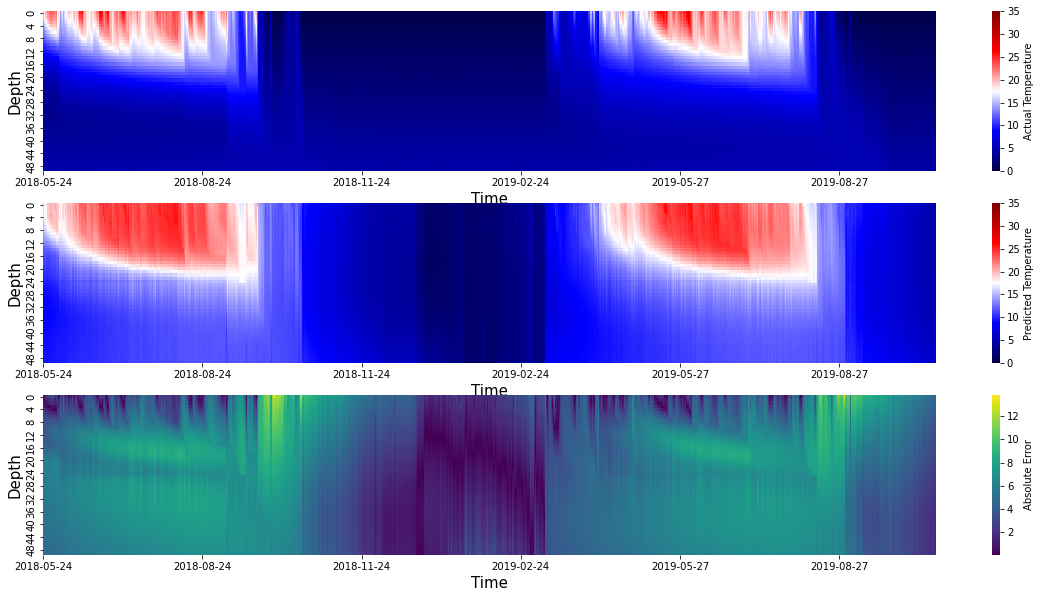

In [40]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

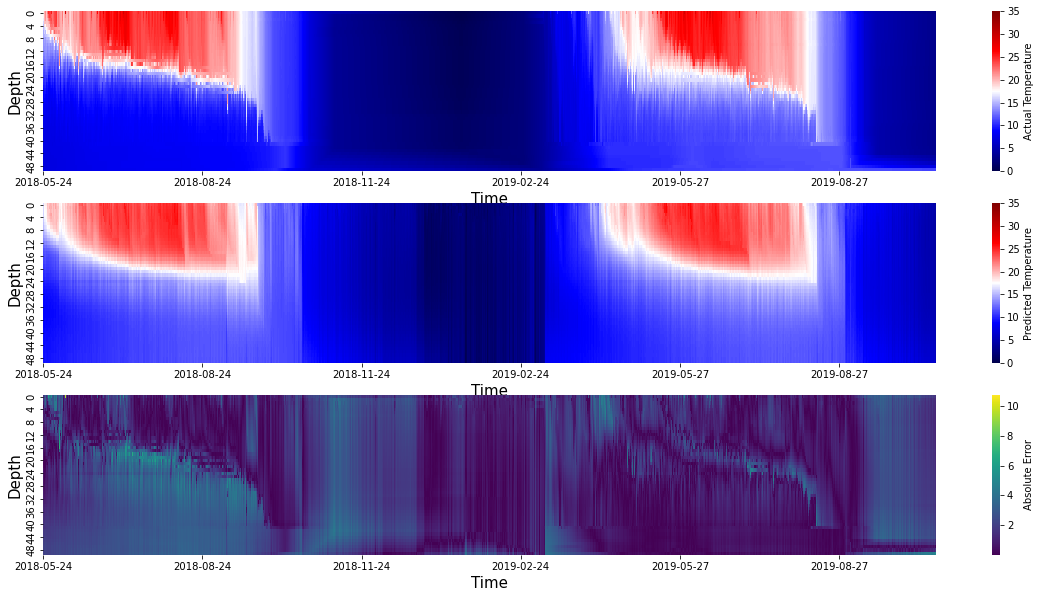

In [41]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [42]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 4.760501251266006, Train L2 Error: 0.6630348560693637
Test RMSE: 5.5093714033368, Train L2 Error: 0.6725731217409812


## Mixing Model

## Convection Model

In [43]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.015869904177310025, Train L2 Error: 0.0022104449320295414
Test RMSE: 0.037338841131498976, Train L2 Error: 0.004558462990788645


## Ice Model

In [44]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.011916424143528238, Train L2 Error: 0.0016585208599914363
Test RMSE: 0.07897739329873596, Train L2 Error: 0.0096342043173161


# Compute Model Similarity after Finetuning

In [45]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [46]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [47]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.8845804929733276
L2 Norm: 5.2770795822143555


In [48]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [49]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [50]:
# Freeze all models again and compute finetuned diffusivity values

In [51]:
# Unfreeze diffusion model and finetune it on projected diffusivities

In [52]:
PATH = f"./saved_models/diffusion_model_finetuned.pth"
torch.save(heat_diff_model.state_dict(), PATH)

In [53]:
def plot_output_freeLimits(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='seismic')
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='seismic')
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

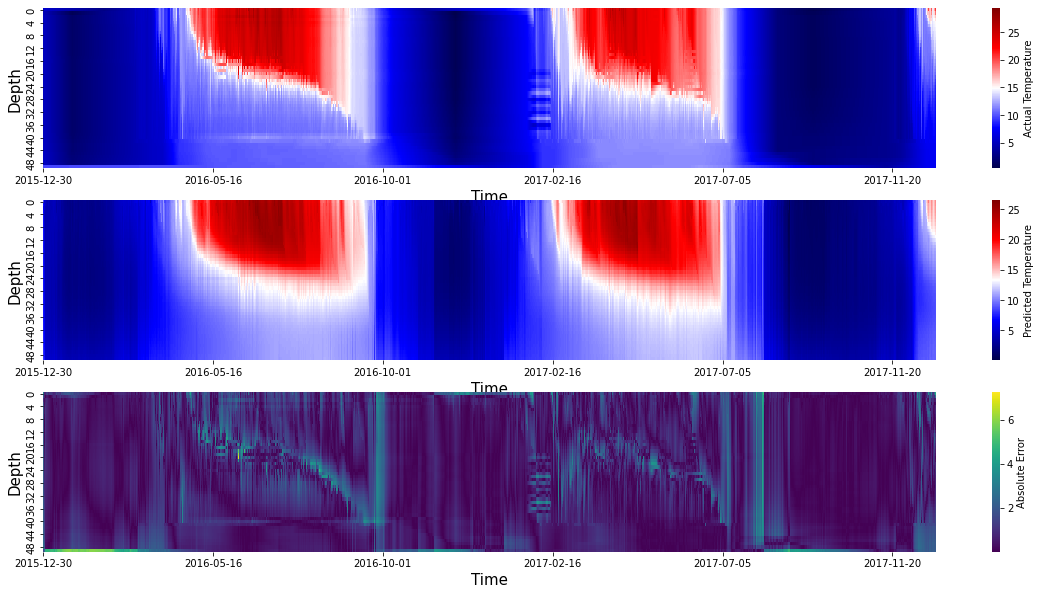

In [54]:
plot_output_freeLimits(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

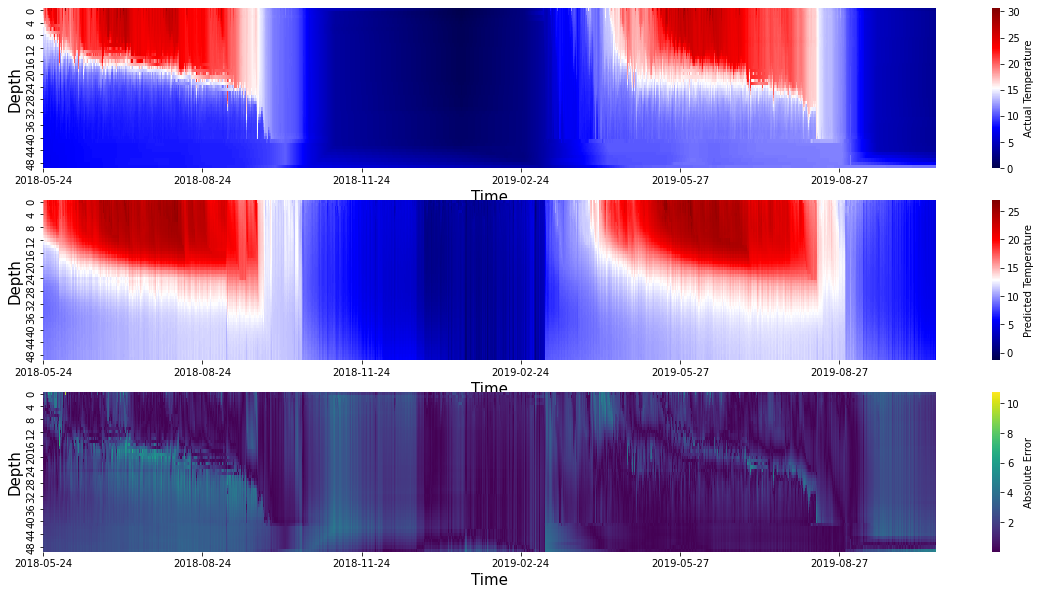

In [55]:
plot_output_freeLimits(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))